In [ ]:
!pip install praw
import praw

reddit = praw.Reddit(client_id='aCsxA497160GjRop_8DDXA',
                     client_secret='rAuMc2mxJPwLMsX4xYqNrpg5ifa7ig',
                     user_agent='a reddit instance',
                     username='DistinctCap2574',
                     password='this is the password',
                     check_for_async=False)



In [ ]:
for submission in reddit.subreddit("learnpython").hot(limit=10):
    print(submission.title)
    print(submission.score)
    print(submission.url)
    print(submission.author)

In [ ]:
for comment in reddit.subreddit("learnpython+python").comments():
  print(comment.body)

In [ ]:
trigger_phrase = "and"
for comment in reddit.subreddit("learnpython+python").stream.comments():
  if trigger_phrase in comment.body.lower():
    print(comment.body)

In [ ]:
import time
for submission in reddit.subreddit("all").stream.submissions():
  submission.upvote()
  submission.clear_vote()
  # submission.downvote()
  submission.reply("hello")
  time.sleep(15)

In [ ]:
subreddit = reddit.subreddit("johntesting")
subreddit.subscribe()
subreddit.unsubscribe()

In [ ]:
user = "Alternative-Use-2277"
reddit.redditor(user).message("Hello", "I am john")

In [ ]:
subreddit.submit("Hello", "I am John")

In [ ]:
import time
trigger_phrase = "do something"
messages = reddit.inbox.stream()
for message in messages:
  try:
    if message in reddit.inbox.mentions() and message in reddit.inbox.unread():
      if trigger_phrase in message.body:
        message.reply("*Does something*")
        print(message.body)
      message.mark_read()
  except praw.exception.APIException:
    print("Probably a rate limit :(")
  time.sleep(15)


In [ ]:
import requests
import bs4
import random
import time
trigger_phrase = "fact"
messages = reddit.inbox.stream()
for message in messages:
  try:
    if message in reddit.inbox.mentions() and message in reddit.inbox.unread():
      if trigger_phrase in message.body:
        res = requests.get("https://www.kickassfacts.com/fact-of-the-day/")
        res.raise_for_status()
        soup = bs4.BeautifulSoup(res.text, "html.parser")
        soupy = soup.select("div > ol > li")
        ran_int = random.randint(1,30)
        fact = soupy[ran_int].getText()
        fact = fact[:-8]

        message.reply(fact)
        print(fact)

        message.mark_read()
  except praw.exception.APIException:
    print("Probably a rate limit :(")
  time.sleep(15)

In [ ]:
subreddit = reddit.subreddit("Johntesting").new()

def has_flair():
  while True:
    for sub in subreddit:
      if sub.link_flair_text:
        print(sub.link_flair_text)
      else:
        print("No flair")

        sub.mod.remove()
        poster = sub.author
        reddit.redditor(str(poster)).message("Your post was removed from r/Johntesting", "You didn't have a flair")

        time.sleep(30)

has_flair()

In [ ]:
banned_words = ["heck", "frick"]

for comment in reddit.subreddit("Johntesting").stream.comments():
  for i in range(len(banned_words)):
    if banned_words[i] in comment.body:
      comment.mod.remove()
      poster = str(comment.author)
      reddit.redditor(poster).message("Your post was banned from r/Johntesting", "You said a bad word")
      
      print(comment.body)
      time.sleep(10)

In [ ]:
import praw
# !pip install heapq
# !pip install yahoo_fin
from heapq import nlargest
from yahoo_fin import stock_info as si

def get_price(stock_ticker):
  return (si.get_live_price(stock_ticker))

numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 0, " ", ".", ";", ")", ",", "$", "?", ">", "<", "\"", "!", "+", "-", "*"]
phrase = "$"
all_stocks = []
rankings = {}
stock_prices = {}

for comment in reddit.subreddit("wallstreetbets+stocks+personalfinance").stream.comments():
  if phrase in comment.body:
    index = comment.body.index(phrase)
    ticker = ""
    ticker += comment.body[index]
    x = 1
    try:
        if comment.body[index + x] in str(numbers):
          continue
    except:
        continue
    while True:
        try:
            if comment.body[index + x] not in numbers:
              ticker += comment.body[index + x]
              x += 1
            
            else:
              break
        except:
          break

    ticker = ticker.upper()
    if len(ticker) > 6:
      continue
    
    if ticker not in all_stocks:
      all_stocks.append(ticker)
      rankings[ticker] = 1
    
    elif ticker in all_stocks:
      rankings[ticker] += 1
    
    largest = nlargest(5, rankings, key=rankings.get)

    for i in range(len(largest)-1):
      a = largest[i]
      no_dollar = a[1:]
      try:
        stock_prices[largest[i]] = get_price(no_dollar)
      except:
        continue

    print(rankings)
    print(largest)
    print(stock_prices)
    print("\n")




In [ ]:
# https://github.com/tstewart161/Reddit_Sentiment_Trader/blob/main/main.py
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import praw
import matplotlib.pyplot as plt
import math
import datetime as dt
import pandas as pd
import numpy as np


# In[2]:


nltk.download('vader_lexicon')
nltk.download('stopwords')


sub_reddits = reddit.subreddit('wallstreetbets')
stocks = ["GME", "AMC", "TSLA"] 
# For example purposes. To use this as a live trading tool, you'd want to populate this with tickers that have been mentioned on the pertinent community (WSB in our case) in a specified period.


# In[5]:


def commentSentiment(ticker, urlT):
    subComments = []
    bodyComment = []
    try:
        check = reddit.submission(url=urlT)
        subComments = check.comments
    except:
        return 0
    
    for comment in subComments:
        try: 
            bodyComment.append(comment.body)
        except:
            return 0
    
    sia = SIA()
    results = []
    for line in bodyComment:
        scores = sia.polarity_scores(line)
        scores['headline'] = line

        results.append(scores)
    
    df =pd.DataFrame.from_records(results)
    df.head()
    df['label'] = 0
    
    try:
        df.loc[df['compound'] > 0.1, 'label'] = 1
        df.loc[df['compound'] < -0.1, 'label'] = -1
    except:
        return 0
    
    averageScore = 0
    position = 0
    while position < len(df.label)-1:
        averageScore = averageScore + df.label[position]
        position += 1
    averageScore = averageScore/len(df.label) 
    
    return(averageScore)


# In[6]:


def latestComment(ticker, urlT):
    subComments = []
    updateDates = []
    try:
        check = reddit.submission(url=urlT)
        subComments = check.comments
    except:
        return 0
    
    for comment in subComments:
        try: 
            updateDates.append(comment.created_utc)
        except:
            return 0
    
    updateDates.sort()
    return(updateDates[-1])


# In[7]:


def get_date(date):
    return dt.datetime.fromtimestamp(date)


# In[8]:


submission_statistics = []
d = {}
for ticker in stocks:
    for submission in reddit.subreddit('wallstreetbets').search(ticker, limit=130):
        if submission.domain != "self.wallstreetbets":
            continue
        d = {}
        d['ticker'] = ticker
        d['num_comments'] = submission.num_comments
        d['comment_sentiment_average'] = commentSentiment(ticker, submission.url)
        if d['comment_sentiment_average'] == 0.000000:
            continue
        d['latest_comment_date'] = latestComment(ticker, submission.url)
        d['score'] = submission.score
        d['upvote_ratio'] = submission.upvote_ratio
        d['date'] = submission.created_utc
        d['domain'] = submission.domain
        d['num_crossposts'] = submission.num_crossposts
        d['author'] = submission.author
        submission_statistics.append(d)
    
dfSentimentStocks = pd.DataFrame(submission_statistics)

_timestampcreated = dfSentimentStocks["date"].apply(get_date)
dfSentimentStocks = dfSentimentStocks.assign(timestamp = _timestampcreated)

_timestampcomment = dfSentimentStocks["latest_comment_date"].apply(get_date)
dfSentimentStocks = dfSentimentStocks.assign(commentdate = _timestampcomment)

dfSentimentStocks.sort_values("latest_comment_date", axis = 0, ascending = True,inplace = True, na_position ='last') 

dfSentimentStocks


# In[9]:


dfSentimentStocks.author.value_counts()


# In[10]:


dfSentimentStocks.to_csv('Reddit_Sentiment_Equity.csv', index=False) 


# In[ ]:

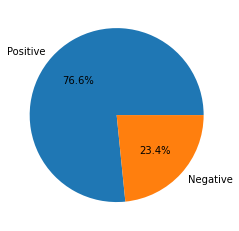

In [ ]:
#!pip install matplotlib
#!pip install nltk
#!pip install datetime
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import nltk
#nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

import time

def sentiment_analysis(subreddit, time_running):
  sizes = [0,0]
  end_time = datetime.now() + timedelta(seconds=time_running)
  for comment in reddit.subreddit(subreddit).stream.comments():
    if datetime.now() > end_time:
      break
    results = analyzer.polarity_scores(comment.body)
    sentiment = results["compound"]

    if sentiment > 0.5:
      sizes[0] += 1

    elif sentiment < -0.5:
      sizes[1] += 1

  return sizes

labels = ["Positive", "Negative"]

plt.pie(sentiment_analysis("ethereum", 60), labels=labels, autopct="%1.1f%%")
plt.show()


In [ ]:
!pip install cryptocompare
import cryptocompare
!pip install datetime
from datetime import date
from datetime import timedelta
import matplotlib.pyplot as plt

today = date.today()

def price_change(crypto_ticker):
  yesterday = today - timedelta(days=1)
  date = yesterday.strftime("%y,%m,%d")
  current_price = cryptocompare.get_price(crypto_ticker)[crypto_ticker]["EUR"]

  yesterday_price = cryptocompare.get_historical_price(crypto_ticker, "EUR", yesterday)[crypto_ticker]["EUR"]

  percent_change = ((current_price - yesterday_price) / yesterday_price) * 100
  change = ""
  if percent_change > 0:
    change = "increase"
  if percent_change < 0:
    change = "decrease"

  print(f"{percent_change}% {change} in the last day") 

price_change("DOGE")

In [ ]:
from datetime import datetime

def keywords(subreddit, keyword1, keyword2, time_running):
  keyword_counter = [0,0]
  end_time = datetime.now() + timedelta(seconds=time_running)
  for comment in reddit.subreddit(subreddit).stream.comments():
    if datetime.now() > end_time:
      break
    if keyword1 in comment.body.lower():
      keyword_counter[0] += 1
    elif keyword2 in comment.body.lower():
      keyword_counter[1] += 1

  return keyword_counter

labels = ["positive", "negative"]
plt.pie(keywords("Bitcoin", "positive", "negative", 60), labels=labels, autopct="%1.1f%%")

plt.show()

price_change("BTC")

In [ ]:
import random
import time
def karma():
  try:
    messages = ["Upvoted, upvote in return?", "Great post, care to share the upvotes!"]
    for submission in reddit.subreddit("FreeKarma4U+FreeKarma4You").stream.submissions():
      submission.upvote()
      rand = random.randint(0, (len(messages)-1))
      print(submission.title)
      submission.reply(messages[rand])
      time.sleep(30)
  except:
    time.sleep(300)
    karma()
karma()

In [ ]:
import time
trigger_phrase = "a"
for comments in reddit.subreddit("BTC").stream.comments():
 if trigger_phrase in comments.body.lower():
   print(comments.body, comments.author)
   time.sleep(5)

    

In [ ]:
import time
def keyword():
  trigger_phrase = ["b", "a"]

  for comment in reddit.subreddit("gaming").stream.comments():
    for i in range(len(trigger_phrase)):
      if trigger_phrase[i] in comment.body:
        name = comment.author.name
        title = f"Hello, {name}"
        text = "Buy my game"
        try:
          reddit.redditor(name).message(title, text)
        except:
          continue
        print(f"u/{name}, Comment body: {comment.body}")
        time.sleep(5)
        continue

keyword()
